In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import torch.utils.data as data
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

In [3]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
print(f"Found { len(center_depth_paths)} data points")

Found 118577 data points


In [9]:
from utils import depth2colorjet, random_flip, crop_roi, depthToLogDepth
import cv2
def build_df_from_y(y):
    throttles, steerings = [], []
    for st_path in y:
        array = np.load(st_path)
        throttles.append(array[-2])
        steerings.append(array[-1])
    df = pd.DataFrame(
        data={"throttle":throttles, "steering":steerings}
    )
    return df

class CarDataset(data.Dataset):
    def __init__(self, X, y, img_width=64, img_height=64, should_take_roi=False, roi_min_height=30,
                 should_use_log_depth=True, should_stack=False, resize=None):
        self.X = X
        self.y = y
        self.img_width=img_width
        self.img_height=img_height
        self.should_take_roi = should_take_roi
        self.roi_min_height = roi_min_height
        self.should_use_log_depth=should_use_log_depth
        self.should_stack = should_stack
        self.resize = resize
        self.df = build_df_from_y(self.y)

    def __getitem__(self, index):
        if np.random.rand(1)[0] < 0.7:
            rand_index = self.df[abs(self.df["steering"]) > 0.25].sample(1).index[0]
            return self.get_item_helper(rand_index)
        else:
            return self.get_item_helper(index)

    def get_item_helper(self, index):
        img_path = self.X[index]
        veh_state_path = self.y[index]
        steering_angle = np.load(veh_state_path)[-1]
        img = np.load(img_path)
        if self.should_take_roi: # will not enter
            img = img[30:self.img_width, :]
        if self.should_use_log_depth:
            img = depthToLogDepth(img)
        if self.resize is not None:
            img = cv2.resize(img, (self.resize))
        
        # generate random noise to the image
        img, steering_angle = random_flip(img, steering_angle)
        return img, steering_angle
        
        
    def __len__(self):
        return len(self.X)

    

### Use monte carlo method to understand our distribution

In [10]:
def describe_loader(loader, N=100):
    i = 0
    loader_generator = iter(loader)
    steerings = []
    while i < N:
        img, steering = next(loader_generator)
        angles = steering.numpy()
        for angle in angles:
            steerings.append(angle)
        i += 1
    df = pd.DataFrame(
        data={"steering":steerings}
    )
    df.hist("steering"), df.describe()

## Split data into Train and valid sets

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(center_depth_paths, 
                                                      veh_state_paths, 
                                                      test_size=0.1, 
                                                      shuffle=True)


In [12]:
batch_size = 1
car_train_loader = DataLoader(CarDataset(X=X_train, y=y_train), 
                              batch_size=batch_size, shuffle=True)
car_valid_loader = DataLoader(CarDataset(X=X_valid, y=y_valid), 
                              batch_size=batch_size, shuffle=True)


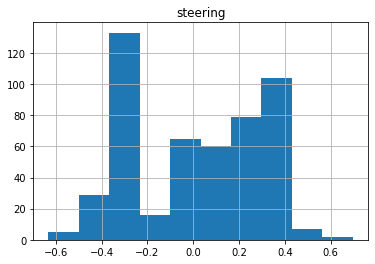

In [13]:
describe_loader(car_train_loader, N=500)

In [14]:
imgs, angles = next(iter(car_train_loader))
imgs.shape, angles.shape, len(car_train_loader)

(torch.Size([1, 600, 800]), torch.Size([1]), 106719)

In [15]:
from model import CarModel


In [16]:
def toTensor(data, use_cuda, device=None):
    img, target = data
#     img, target = torch.from_numpy(img).float(), torch.from_numpy(np.array([target])).float()
    img = img.float()
    target = target.float()
    if use_cuda:
        img, target = img.to(device), target.to(device)
    return img, target

In [17]:
best_loss = 1000000

def train(epoch, net, train_loader, optimizer, criterion, use_cuda, 
          device=None, save_dir=Path("."),MAX_BATCH=1000):
    net.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        img, steering_angle = toTensor(data, use_cuda, device)
        output = net(img) # Tensor([ITEM])
        loss = criterion(output, steering_angle)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        if batch_idx % 100 == 0:
            print(f'    Batch: {batch_idx} --> Loss: {train_loss / (batch_idx+1)}') 
        
        if batch_idx >= MAX_BATCH:
            break
    

def valid(epoch, net, validloader, criterion, use_cuda, device=None, save_dir=Path("."),MAX_BATCH=1000):
    global best_loss
    net.eval()
    valid_loss = 0 
    for batch_idx, data in enumerate(validloader):
        img, steering_angle = toTensor(data, use_cuda, device)
        outputs = net(img)
        loss = criterion(outputs, steering_angle)
        valid_loss += loss.data.item()
        
        avg_valid_loss = valid_loss / (batch_idx + 1)
        if batch_idx % 100 == 0:
            print(f"    Valid Loss: {avg_valid_loss}" )
        
        if avg_valid_loss <= best_loss:
            best_loss = avg_valid_loss
            print(f"         Saving.... Best epoch: {epoch} -> {avg_valid_loss}")
            torch.save(net.state_dict(),save_dir / "best_model_state_dict.h5" )
#             torch.save(net, save_dir / "best_model.h5")
        
        if batch_idx >= MAX_BATCH:
            break
    
    torch.save(net.state_dict(),save_dir / "model_state_dict.h5")


In [18]:
#load the previous net or use new net
# net = torch.load("/home/michael/Desktop/projects/ROAR/misc/data/best_model.h5")
# net.training = True

net = CarModel(batch_size=batch_size, 
              image_width=800,
              image_height=600)


/home/michael/anaconda3/envs/ROAR3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
optimizer = optim.Adam(net.parameters(), lr=1e-5)
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

In [20]:
save_dir = Path("./data")
save_dir.mkdir(exist_ok=True, parents=True)
if use_cuda:
    net.to(device)
for epoch in range(0, 10):
    print(f"Epoch {epoch}")
    train(epoch, net, car_train_loader, optimizer, criterion, use_cuda, device=device, save_dir=save_dir, 
          MAX_BATCH=len(car_train_loader)//4)
    valid(epoch, net, car_valid_loader, criterion, use_cuda, device=device, save_dir=save_dir, MAX_BATCH=1000)

Epoch 0
    Batch: 0 --> Loss: 0.12930475175380707
    Batch: 100 --> Loss: 0.1213341714823004
    Batch: 200 --> Loss: 0.10911168004131197
    Batch: 300 --> Loss: 0.09655893557135078
    Batch: 400 --> Loss: 0.08682453820924518
    Batch: 500 --> Loss: 0.07987128551911658
    Batch: 600 --> Loss: 0.07352255209667478
    Batch: 700 --> Loss: 0.0658066236480989
    Batch: 800 --> Loss: 0.06006317603200967
    Batch: 900 --> Loss: 0.05581457245647643
    Batch: 1000 --> Loss: 0.05281737198390654
    Batch: 1100 --> Loss: 0.049635106871046324
    Batch: 1200 --> Loss: 0.04714078195118114
    Batch: 1300 --> Loss: 0.04443407174023898
    Batch: 1400 --> Loss: 0.042477292587460566
    Batch: 1500 --> Loss: 0.04045581227663706
    Batch: 1600 --> Loss: 0.038910089365243906
    Batch: 1700 --> Loss: 0.037707500147060105
    Batch: 1800 --> Loss: 0.0367383973318749
    Batch: 1900 --> Loss: 0.03553477820688362
    Batch: 2000 --> Loss: 0.03453198164653629
    Batch: 2100 --> Loss: 0.033727048

    Batch: 17500 --> Loss: 0.016955271979019956
    Batch: 17600 --> Loss: 0.016904738931701163
    Batch: 17700 --> Loss: 0.016861603012617698
    Batch: 17800 --> Loss: 0.01681739524603371
    Batch: 17900 --> Loss: 0.01678186889270917
    Batch: 18000 --> Loss: 0.016764483523338338
    Batch: 18100 --> Loss: 0.016719852506620465
    Batch: 18200 --> Loss: 0.016679631920189678
    Batch: 18300 --> Loss: 0.01671729823730133
    Batch: 18400 --> Loss: 0.0166847839581468
    Batch: 18500 --> Loss: 0.016660034509203395
    Batch: 18600 --> Loss: 0.01662219317069713
    Batch: 18700 --> Loss: 0.016607074210961206
    Batch: 18800 --> Loss: 0.01656750855270407
    Batch: 18900 --> Loss: 0.016550535027461847
    Batch: 19000 --> Loss: 0.016524215912445975
    Batch: 19100 --> Loss: 0.016508389247237906
    Batch: 19200 --> Loss: 0.01647517511688955
    Batch: 19300 --> Loss: 0.016463259322508778
    Batch: 19400 --> Loss: 0.01643439241780796
    Batch: 19500 --> Loss: 0.01640980286507978
  

    Batch: 6900 --> Loss: 0.009721681680389598
    Batch: 7000 --> Loss: 0.009652008026840391
    Batch: 7100 --> Loss: 0.009626605319128881
    Batch: 7200 --> Loss: 0.009653179157010439
    Batch: 7300 --> Loss: 0.009619696689262854
    Batch: 7400 --> Loss: 0.009597292591444439
    Batch: 7500 --> Loss: 0.009563131185914463
    Batch: 7600 --> Loss: 0.009563112248414664
    Batch: 7700 --> Loss: 0.009557151174079112
    Batch: 7800 --> Loss: 0.00955186317207266
    Batch: 7900 --> Loss: 0.00952354155615313
    Batch: 8000 --> Loss: 0.009548821989909107
    Batch: 8100 --> Loss: 0.00954925781661976
    Batch: 8200 --> Loss: 0.009547303136863958
    Batch: 8300 --> Loss: 0.009526569998745082
    Batch: 8400 --> Loss: 0.009505535063097613
    Batch: 8500 --> Loss: 0.009474104442929883
    Batch: 8600 --> Loss: 0.00946803788708148
    Batch: 8700 --> Loss: 0.009531237304439772
    Batch: 8800 --> Loss: 0.00950017753368076
    Batch: 8900 --> Loss: 0.009477319668986956
    Batch: 9000 --

KeyboardInterrupt: 

In [17]:
valid_iter = iter(car_valid_loader)
net.eval()
for i in range(100):
    img, angle = next(valid_iter)
    angle = angle.numpy()[0]
    predicted = net(img.float().to(device)).cpu().detach().numpy()[0]
    print(predicted, angle)

0.2572979 0.247793510556221
-0.24644285 -0.23011928796768188
0.27391472 0.3711860775947571
0.2573366 0.3710019886493683
-0.12147804 -0.07343771308660507
0.1489084 0.24445492029190063
-0.21758002 -0.2101329267024994
-0.14934948 -0.20807412266731262
-0.23870525 -0.23123469948768616
0.22465569 0.2074546217918396
0.047944836 0.031077463179826736
-0.13415655 -0.07748732715845108
0.21049064 0.2122012823820114
0.17843717 0.05034371465444565
0.053923912 0.07145029306411743
-0.1585224 -0.21463623642921448
-0.047052696 0.02933523990213871
0.22325256 0.22274674475193024
0.22667295 0.20325329899787903
0.16792546 0.08929488807916641
-0.28596342 -0.31280726194381714
-0.1716949 -0.206185981631279
-0.2584745 -0.22814881801605225
0.1634875 0.21009241044521332
0.0223137 0.28685715794563293
-0.13322711 0.04804837331175804
0.23795572 0.21330009400844574
0.20664993 0.20744571089744568
-0.22905114 -0.21201227605342865
0.19513035 0.11184201389551163
-0.21932608 -0.2076878547668457
0.22515023 0.40488389134407

In [25]:
torch.save(net.state_dict(),save_dir / "model_state_dict.h5")